In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


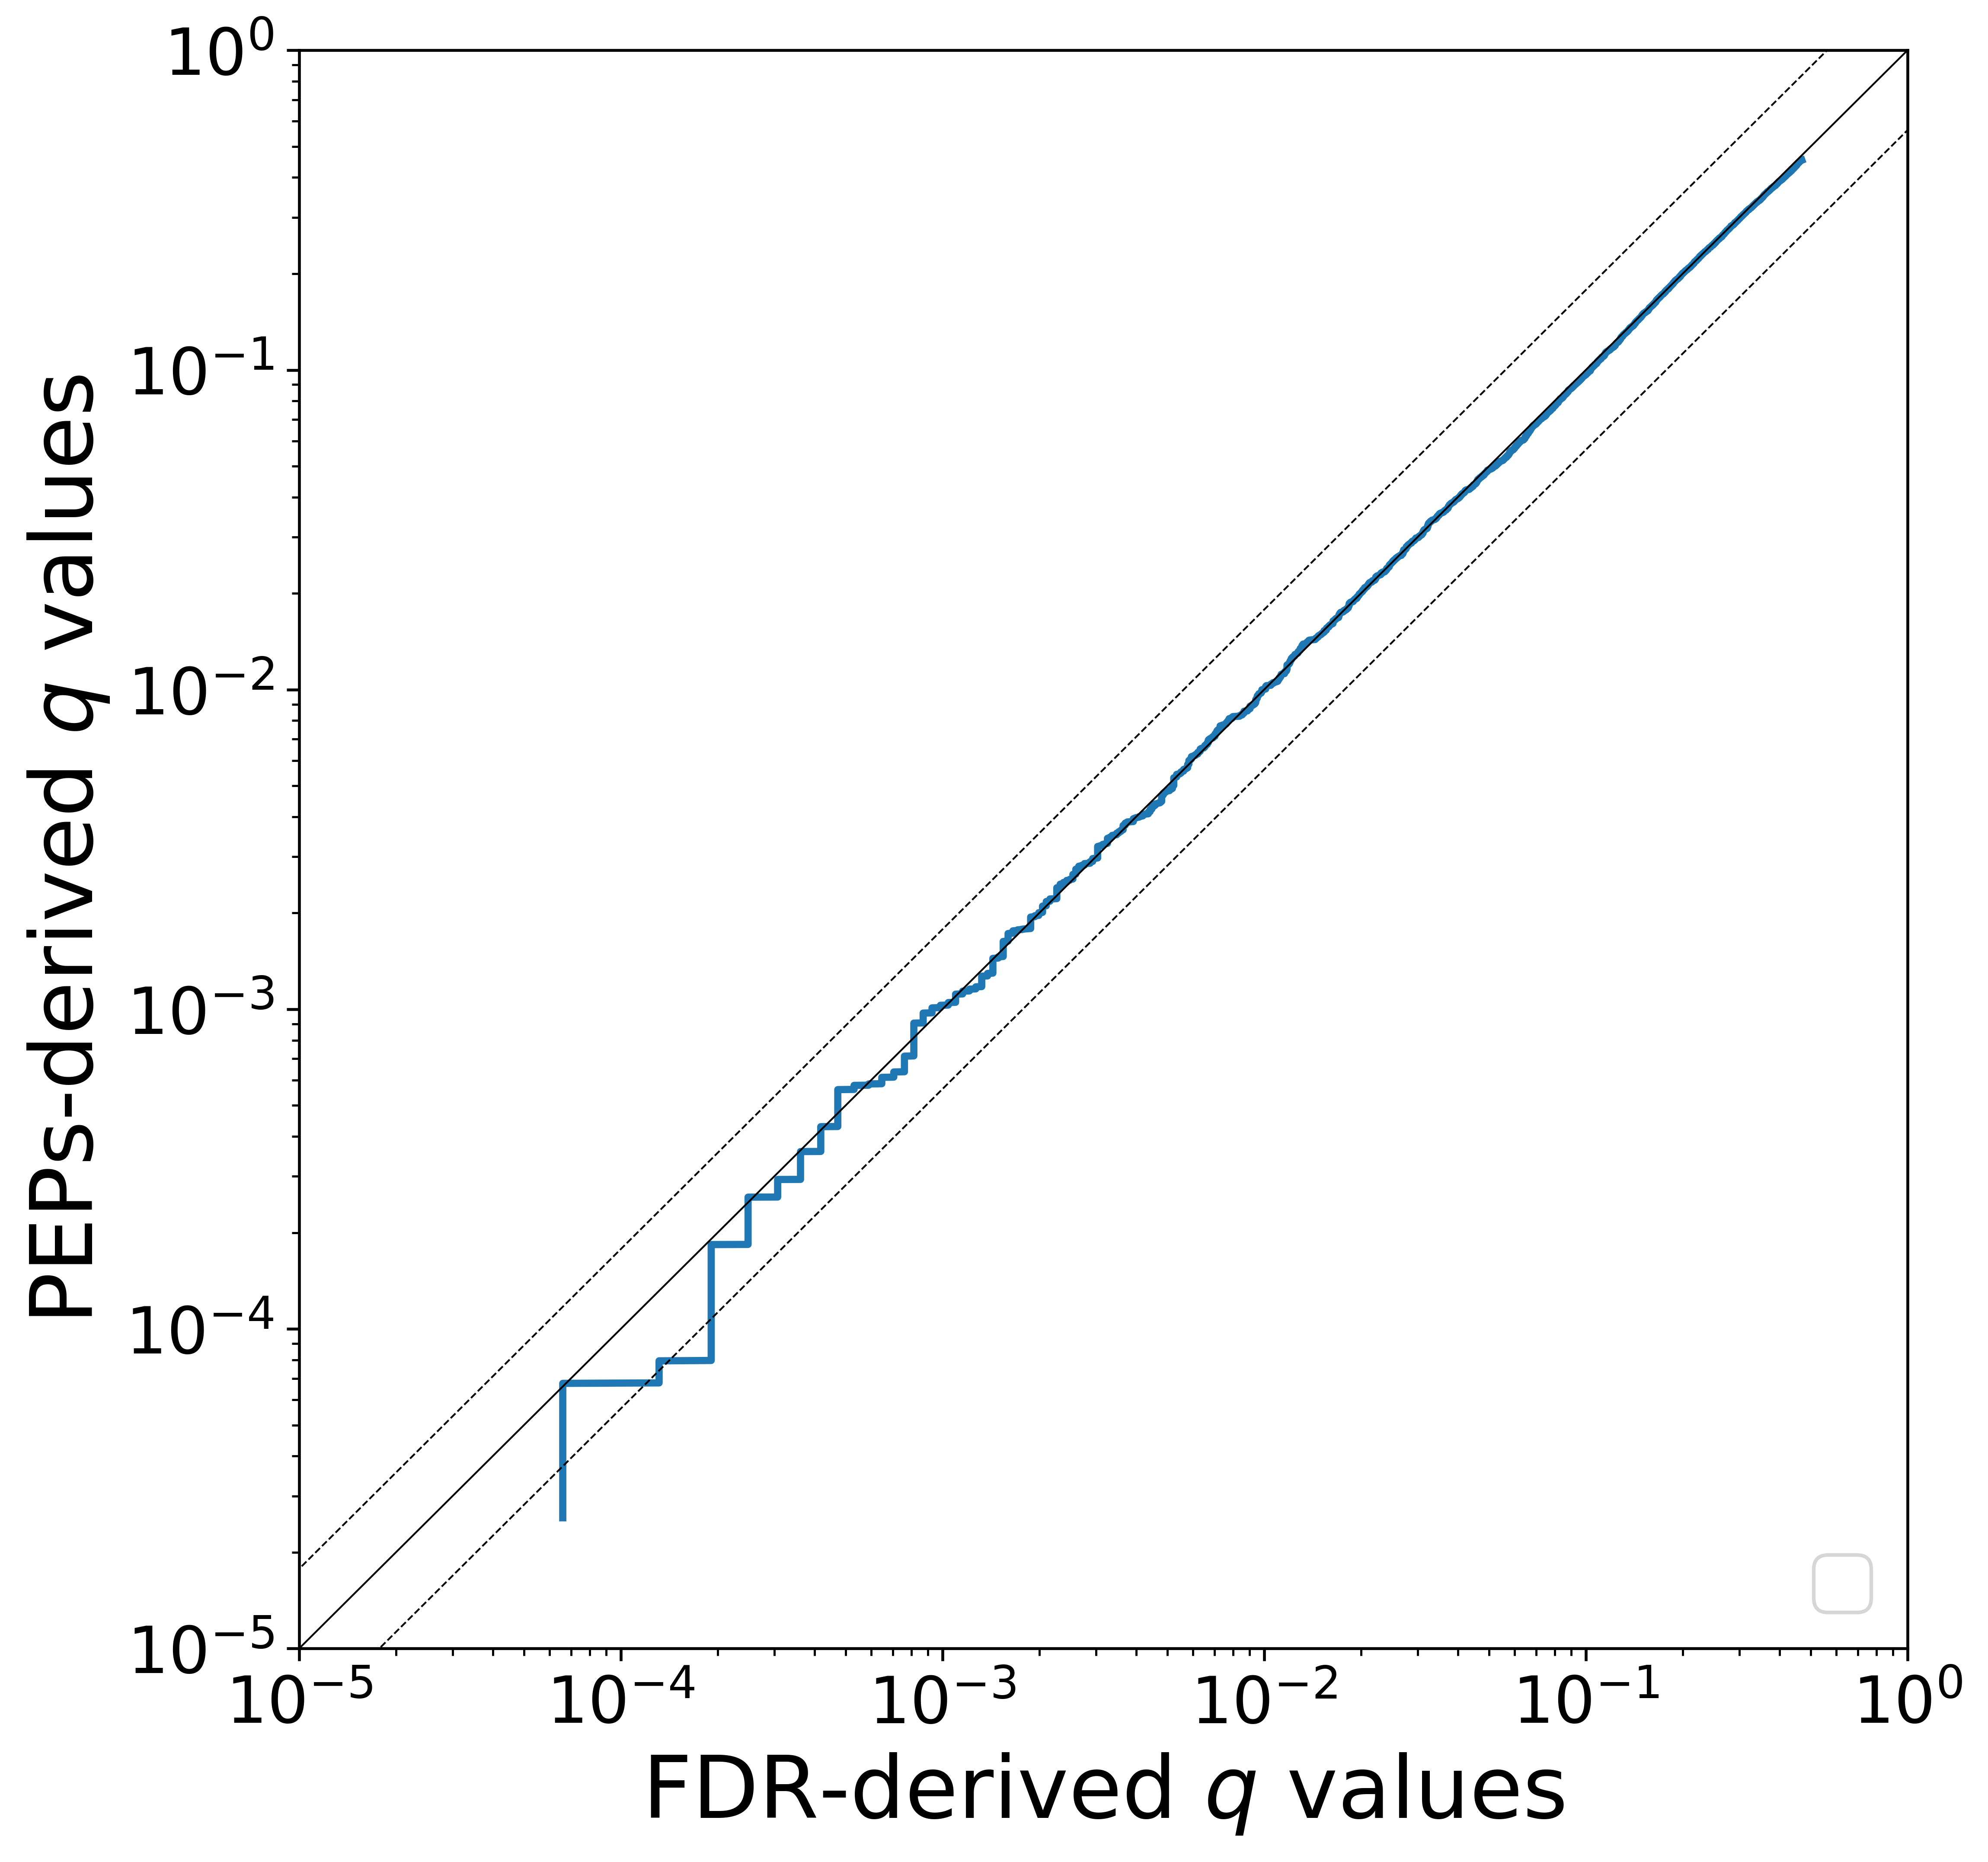

In [5]:
output_dir = "/home/yuqizh/quickt/april2"
plt.figure(figsize=(8, 8), dpi=600)
df = pd.read_csv(f"/home/yuqizh/smooth_q_to_pep/example/results/outputPEP.target.dbased.txt", sep="\t")
plt.plot(df["q-value"], df["pyIsoPEP q-value from PEP"], linewidth=2)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=24)
plt.ylabel("PEPs-derived $q$ values", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=20)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.00001, 1)
plt.ylim(0.00001, 1)
# plt.savefig(f"figs/interp_vs_basic.logit_mean_bm.png",bbox_inches="tight")
plt.show()

```bash
~/smooth_q_to_pep/pyiso_test$ rsync -av --exclude='crux' --exclude='interm' --exclude='logs' x_yuqzh@tetralith.nsc.liu.se:/proj/proteoforma_nsc/smooth_q_to_pep/pyiso_test/ .

~/smooth_q_to_pep/pyiso_test$ rsync -av --exclude='crux' --exclude='interm' --exclude='logs' --exclude='dISpline' --exclude='dPAVA' --exclude='percolator' --exclude='qISpline' --exclude='qPAVA' --exclude='qipPAVA' x_yuqzh@tetralith.nsc.liu.se:/proj/proteoforma_nsc/smooth_q_to_pep/pyiso_test/ .
```

In [ ]:
def estimate_q(df):
    df.index += 1
    df["est_q"] = df["posterior_error_prob"].cumsum() / df.index
    return df

def estimate_and_save(output_dir, N_values):
    for n in N_values:
        df = pd.read_csv(f"{output_dir}/{n}/peptide.target.txt", sep="\t")
        df = estimate_q(df)
        columns_to_drop = ["PSMId", "filename", "peptide", "proteinIds"]
        df = df.drop(columns=columns_to_drop)
        df.to_csv(f"{output_dir}/{n}/q_pep.txt", sep='\t', index=False)

datasets = ["PXD003868", "PXD004325", "PXD004424", "PXD004467", "PXD004536", "PXD004565", "PXD004947", "PXD004948", "PXD005025", "PXD013274"]
for dataset in datasets:
    output_dir = f"pyiso_test/{dataset}"
    models = ["irls", "ispline.rank", "ispline.score", "pava.rank", "pava.score"]
    N_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 40]
    num_runs = 10
    for n in range(1, num_runs + 1):
        
        for model in models:
            print(n, dataset, model)
            estimate_and_save(f"{output_dir}/run{n}/{model}", N_values)

In [ ]:
N = 2
run = 10
output_dir = "pyiso_test/PXD003868"
models = ["irls"]
plt.figure(figsize=(8, 8), dpi=600)
plt.text(0.05, 0.9, f"N = {N}, Run {run}", transform=plt.gca().transAxes, fontsize=18, fontweight='bold')
for model in models:
    df = pd.read_csv(f"{output_dir}/run{run}/{model}/{N}/q_pep.txt", sep="\t")
    # df = pd.read_csv(f"{output_dir}/run{run}/{model}/{N}/peptide.target.txt", sep="\t")
    plt.plot(df["q-value"], df["est_q"], label=f"{model}", linewidth=2)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=24)
plt.ylabel("PEPs-derived $q$ values", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.00001, 1)
plt.ylim(0.00001, 1)
# plt.savefig(f"figs/interp_vs_basic.logit_mean_bm.png",bbox_inches="tight")
plt.show()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def cal_max_rel_diff(q_value, q_est):
    relative_difference = np.abs(q_est - q_value) / np.where(q_value != 0, q_value, np.nan)
    return np.nanmax(relative_difference) * 100

# List of datasets
datasets = [
    "PXD003868", "PXD004325", "PXD004424", "PXD004467", "PXD004536",
    "PXD004565", "PXD004947", "PXD004948", "PXD005025" , "PXD013274"
]

# datasets=["PXD013274"]
# N values to iterate over
N_values = [1, 2, 3, 4, 5, 6, 7, 8, 20, 40]
N_values = [0]
# Number of runs per model
num_runs = 10

# Base directory pattern for the datasets (e.g. "pyiso_test/PXD003868")
base_dir = "pyiso_test"

# Define groups of models
groupA = ["irls", "pava.rank", "ispline.rank"]
groupB = ["irls", "pava.score", "ispline.score"]

# Label mapping for each model
label_map = {
    "irls": r"IRLS",
    "pava.rank":      r"PAVA.rank",
    "ispline.rank":    r"ISpline.rank",
    "pava.score":   r"PAVA.score",
    "ispline.score":      r"ISpline.score"
}

# Define colors for each model (consistent across figures)
color_map = {
    "irls": "tab:blue",
    "pava.rank":      "tab:orange",
    "ispline.rank":    "tab:green",
    "pava.score":      "tab:orange",
    "ispline.score":   "tab:green"
}

# Directory to save figures
save_dir = "figs/pyiso_test"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop over each dataset
for dataset in datasets:
    # Define the output directory for the current dataset
    output_dir = os.path.join(base_dir, dataset)
    
    # Loop over each N value
    for N in N_values:
        # Loop over each group of models with corresponding suffix for filename
        for group_label, suffix, group_models in zip(
            ["rank-based methods", "score-based methods"],
            ["rank", "score"],
            [groupA, groupB]
        ):
            
            # Create a new figure for this dataset, N, and group
            plt.figure(figsize=(8, 8), dpi=600)
            plt.text(0.05, 0.9, f"N = {N}",
                     transform=plt.gca().transAxes, fontsize=18, fontweight='bold')
            plt.text(0.05, 0.83, f"max relative difference:",
                     transform=plt.gca().transAxes, fontsize=18, fontweight='bold')
            cnt = 0
            # Loop over each model in the current group
            for model in group_models:
                color = color_map.get(model, "black")
                
                # 1) Read and combine data for all runs of the current model
                model_runs = []
                for run in range(1, num_runs + 1):
                    file_name = "q_pep.txt"
                    file_path = os.path.join(output_dir, f"run{run}", model, str(N), file_name)
                    # Read only the required columns: "q-value" and "est_q"
                    df_tmp = pd.read_csv(file_path, sep="\t", usecols=["q-value", "est_q"])
                    df_tmp["run"] = run
                    model_runs.append(df_tmp)
                df_model = pd.concat(model_runs, ignore_index=True)
                
                # 2) Collect all unique q-value points (the step points)
                unique_q = np.unique(df_model["q-value"].values)
                unique_q.sort()
                aligned_df = pd.DataFrame({"q-value": unique_q})
                
                # 3) For each run, align its step function onto the shared q-value grid
                for run in range(1, num_runs + 1):
                    df_run = df_model[df_model["run"] == run].sort_values("q-value")
                    run_qvals = df_run["q-value"].values
                    run_qests = df_run["est_q"].values
                    aligned_values = []
                    current_index = 0
                    current_qest = run_qests[0]
                    
                    for q in unique_q:
                        # Extend the previous value until a new q-value is reached
                        while current_index < len(run_qvals) and q >= run_qvals[current_index]:
                            current_qest = run_qests[current_index]
                            current_index += 1
                        aligned_values.append(current_qest)
                    aligned_df[f"run_{run}"] = aligned_values
                
                # 4) Compute mean and standard deviation at each q-value point
                run_cols = [col for col in aligned_df.columns if col.startswith("run_")]
                aligned_df["mean"] = aligned_df[run_cols].mean(axis=1)
                aligned_df["std"] = aligned_df[run_cols].std(axis=1)
                
                # Calculate average max relative difference for this model over all runs
                max_diffs = []
                for run in range(1, num_runs + 1):
                    diff = cal_max_rel_diff(aligned_df["q-value"].values, aligned_df[f"run_{run}"].values)
                    max_diffs.append(diff)
                avg_max_diff = np.mean(max_diffs)
                std_max_diff = np.std(max_diffs)
                
                # Print the average max relative difference on the figure
                plt.text(0.05, 0.76 - cnt * 0.05, f"{label_map.get(model, model)}: {avg_max_diff:.0f} ± {std_max_diff:.0f}%",
                         transform=plt.gca().transAxes, fontsize=18)
                cnt += 1

                # 5) Plot the mean step curve with a thicker line
                plt.step(aligned_df["q-value"], aligned_df["mean"],
                         where="post", color=color, linewidth=2, label=label_map.get(model, model))
                
                # 6) Fill the area between mean - std and mean + std using step-fill
                y_lower = aligned_df["mean"] - aligned_df["std"]
                y_upper = aligned_df["mean"] + aligned_df["std"]
                plt.fill_between(aligned_df["q-value"], y_lower, y_upper,
                                 step="post", color=color, alpha=0.2)
            
            # 7) Plot the reference lines
            a = np.linspace(0, 1, 100)
            b = a / 10 ** 0.25
            c = a * 10 ** 0.25
            plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
            plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
            plt.plot(a, a, c="k", linewidth=0.5)
            
            # 8) Configure axes, labels, legend and log scales
            plt.title(f"{group_label}: {dataset}", fontsize=24)
            plt.xlabel("FDR-derived $q$ values", fontsize=24)
            plt.ylabel("PEPs-derived $q$ values", fontsize=24)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.legend(loc='lower right', fontsize=24)
            plt.xscale("log")
            plt.yscale("log")
            plt.xlim(1e-5, 1)
            plt.ylim(1e-5, 1)
            
            # 9) Save the figure
            fig_filename = f"{dataset}_N{N}_{suffix}.png"
            plt.savefig(os.path.join(save_dir, fig_filename), bbox_inches="tight")
            plt.close()
            # plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def cal_max_rel_diff(q_value, q_est):
    relative_difference = np.abs(q_est - q_value) / np.where(q_value != 0, q_value, np.nan)
    return np.nanmax(relative_difference) * 100

# List of datasets
datasets = [
    "PXD003868", "PXD004325", "PXD004424", "PXD004467", "PXD004536",
    "PXD004565", "PXD004947", "PXD004948", "PXD005025", "PXD013274"
]
datasets = ["PXD004325", "PXD004424", "PXD004536", "PXD004947", "PXD004948"]
# datasets=["PXD003868"]
# N values to iterate over
N_values = [0, 1, 2, 3, 4]
N_values = [5, 6, 7, 8]
# N_values = [4]
# Number of runs per model
num_runs = 10

# Base directory pattern for the datasets (e.g. "pyiso_test/PXD003868")
base_dir = "pyiso_test"

# Define groups of models
groupA = ["percolator", "qPAVA", "qipPAVA", "qISpline"]
groupB = ["percolator", "dPAVA", "dISpline"]

# Label mapping for each model
label_map = {
    "percolator": r"$q$: IRLS",
    "qPAVA":      r"$q$: PAVA",
    "qipPAVA":    r"$q$: ipPAVA",
    "qISpline":   r"$q$: I-Spline",
    "dPAVA":      r"$f_D$: PAVA",
    "dISpline":   r"$f_D$: I-Spline"
}

# Define colors for each model (consistent across figures)
color_map = {
    "percolator": "tab:blue",
    "qPAVA":      "tab:orange",
    "qipPAVA":    "tab:green",
    "qISpline":   "tab:gray",
    "dPAVA":      "tab:purple",
    "dISpline":   "tab:pink"
}

# Directory to save figures
save_dir = "figs/pyiso_test"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop over each dataset
for dataset in datasets:
    # Define the output directory for the current dataset
    output_dir = os.path.join(base_dir, dataset)
    
    # Loop over each N value
    for N in N_values:
        # Loop over each group of models with corresponding suffix for filename
        for group_label, suffix, group_models in zip(
            ["$q$ value-based methods", "$D$ $prob.$-based methods"],
            ["q", "d"],
            [groupA, groupB]
        ):
            
            # Create a new figure for this dataset, N, and group
            plt.figure(figsize=(8, 8), dpi=600)
            plt.text(0.05, 0.9, f"N = {N}",
                     transform=plt.gca().transAxes, fontsize=18, fontweight='bold')
            plt.text(0.05, 0.83, f"max relative difference:",
                     transform=plt.gca().transAxes, fontsize=18, fontweight='bold')
            cnt = 0
            # Loop over each model in the current group
            for model in group_models:
                color = color_map.get(model, "black")
                
                # 1) Read and combine data for all runs of the current model
                model_runs = []
                for run in range(1, num_runs + 1):
                    # For percolator, use "q_pep.txt", otherwise use "peptide.target.txt"
                    if model == "percolator":
                        file_name = "q_pep.txt"
                    else:
                        file_name = "peptide.target.txt"
                    
                    file_path = os.path.join(output_dir, f"run{run}", model, str(N), file_name)
                    # Read only the required columns: "q-value" and "est_q"
                    df_tmp = pd.read_csv(file_path, sep="\t", usecols=["q-value", "est_q"])
                    df_tmp["run"] = run
                    model_runs.append(df_tmp)
                df_model = pd.concat(model_runs, ignore_index=True)
                
                # 2) Collect all unique q-value points (the step points)
                unique_q = np.unique(df_model["q-value"].values)
                unique_q.sort()
                aligned_df = pd.DataFrame({"q-value": unique_q})
                
                # 3) For each run, align its step function onto the shared q-value grid
                for run in range(1, num_runs + 1):
                    df_run = df_model[df_model["run"] == run].sort_values("q-value")
                    run_qvals = df_run["q-value"].values
                    run_qests = df_run["est_q"].values
                    aligned_values = []
                    current_index = 0
                    current_qest = run_qests[0]
                    
                    for q in unique_q:
                        # Extend the previous value until a new q-value is reached
                        while current_index < len(run_qvals) and q >= run_qvals[current_index]:
                            current_qest = run_qests[current_index]
                            current_index += 1
                        aligned_values.append(current_qest)
                    aligned_df[f"run_{run}"] = aligned_values
                
                # 4) Compute mean and standard deviation at each q-value point
                run_cols = [col for col in aligned_df.columns if col.startswith("run_")]
                aligned_df["mean"] = aligned_df[run_cols].mean(axis=1)
                aligned_df["std"] = aligned_df[run_cols].std(axis=1)
                
                # Calculate average max relative difference for this model over all runs
                max_diffs = []
                for run in range(1, num_runs + 1):
                    diff = cal_max_rel_diff(aligned_df["q-value"].values, aligned_df[f"run_{run}"].values)
                    max_diffs.append(diff)
                avg_max_diff = np.mean(max_diffs)
                std_max_diff = np.std(max_diffs)
                
                # Print the average max relative difference on the figure
                plt.text(0.05, 0.76 - cnt * 0.05, f"{label_map.get(model, model)}: {avg_max_diff:.0f} ± {std_max_diff:.0f}%",
                         transform=plt.gca().transAxes, fontsize=18)
                cnt += 1

                # 5) Plot the mean step curve with a thicker line
                plt.step(aligned_df["q-value"], aligned_df["mean"],
                         where="post", color=color, linewidth=2, label=label_map.get(model, model))
                
                # 6) Fill the area between mean - std and mean + std using step-fill
                y_lower = aligned_df["mean"] - aligned_df["std"]
                y_upper = aligned_df["mean"] + aligned_df["std"]
                plt.fill_between(aligned_df["q-value"], y_lower, y_upper,
                                 step="post", color=color, alpha=0.2)
            
            # 7) Plot the reference lines
            a = np.linspace(0, 1, 100)
            b = a / 10 ** 0.25
            c = a * 10 ** 0.25
            plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
            plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
            plt.plot(a, a, c="k", linewidth=0.5)
            
            # 8) Configure axes, labels, legend and log scales
            plt.title(f"{group_label}: {dataset}", fontsize=24)
            plt.xlabel("FDR-derived $q$ values", fontsize=24)
            plt.ylabel("PEPs-derived $q$ values", fontsize=24)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.legend(loc='lower right', fontsize=24)
            plt.xscale("log")
            plt.yscale("log")
            plt.xlim(1e-5, 1)
            plt.ylim(1e-5, 1)
            
            # 9) Save the figure
            fig_filename = f"{dataset}_N{N}_{suffix}.png"
            plt.savefig(os.path.join(save_dir, fig_filename), bbox_inches="tight")
            plt.close()
            # plt.show()
